In [0]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd "/content/drive/My Drive/"
!ls

/content/drive/My Drive
 AI   Astronomy   BRP  'Colab Notebooks'   IV   Other   Pics


In [0]:
num_www = 20

WWW = ["who", "what", "where"]

WHO = ["person"+str(i) for i in range(num_www)]
WHAT = ["doing"+str(i) for i in range(num_www)]
WHERE = ["location"+str(i) for i in range(num_www)]

def empty_targets():
  return {"who":[],"what":[],"where":[]}

def get_sentence(lvl=0, targets={}):

  Pwhen = 0.75

  who = np.random.choice(WHO)
  what = np.random.choice(WHAT)
  where = np.random.choice(WHERE)

  parts = [who + " went " + what, "at " + where]

  targets = empty_targets() if lvl==0 else targets
  targets["who"].append(who)
  targets["what"].append(what)
  targets["where"].append(where)

  if np.random.rand() < Pwhen:
    subsentence, targets = get_sentence(lvl=lvl+1, targets=targets)
    parts.append("when " + subsentence)

  np.random.shuffle(parts)
  sentence = " ".join(parts)
  return sentence, targets

In [0]:
def formulate_answer(w1, w2, targets, ask_depth, sentence="", hierarchy="level"):
  q = targets[w2][ask_depth]

  answer = []
  
  #first level first
  if hierarchy == "level":
    #for loop to check for all possible answers
    for i in range(len(targets["who"])):
      if targets[w2][i] == q:
        if w1 == "who" and w2 == "what":
          answer.append(targets[w1][i] + " went " + q)
        elif w1 == "what" and w2 == "who":
          answer.append(q + " went " + targets[w1][i])
        elif w1 == "where" and w2 == "who":
          answer.append(q + " at " + targets[w1][i])
        else: 
          part1 = "at " + targets[w1][i] if w1 == "where" else targets[w1][i]
          part2 = "at " + q if w2 == "where" else q
          answer.append(part1 + " " + part2)

  #first occurence first
  elif hierarchy == "order":
    raise Exception("Working on it!")
  return " ".join(answer) 

def question_props(depth):
  w1, w2 = np.random.choice(WWW, 2, replace=False)
  ask_depth = np.random.randint(depth)
  return w1, w2, ask_depth

def question_answer(sentence, targets, max_tasks=5):
  depth = len(targets["who"])
  num_tasks = np.random.randint(max_tasks)+1
  questions, answers = [], []
  already_asked = []
  for i in range(num_tasks):
    if i == 0:
      w1, w2, ask_depth = question_props(depth)
    else:
      while (w1, w2, ask_depth) in already_asked:
        w1, w2, ask_depth = question_props(depth) 
    already_asked.append((w1, w2, ask_depth))

    question = w1 + " " + targets[w2][ask_depth]
    if question in questions:
      continue 
    answer = formulate_answer(w1, w2, targets, ask_depth)

    questions.append(question)
    answers.append(answer)
  return " ".join(questions), " ".join(answers)

In [0]:
def get_samples(N=10000, max_depth=10, max_tasks=5):
  task_dist = np.zeros(max_tasks)
  samples = set()
  # sample unqique sequences
  while len(samples) < N:
    sentence, targets = get_sentence()


    error = False
    for w in targets["who"]:
      if w not in sentence:
        error = True
    for w in targets["what"]:
      if w not in sentence:
        error = True
    for w in targets["where"]:
      if w not in sentence:
        error = True
    if error:
      print(len(samples))
      print(sentence)
      print(targets)
      raise Exception()
    

    if len(targets["who"]) > max_depth:
      continue
    question, answer = question_answer(sentence, targets, max_tasks=max_tasks)
    model_input = question + " " + sentence
    tasks = num_tasks(model_input)
    task_dist[tasks-1] += 1
    if np.std(task_dist) > 10 or (model_input, answer) in samples:
      task_dist[tasks-1] -= 1
      continue
    samples.add((model_input, answer))
  return samples

def write_data(samples, srcfile="source.txt", tgtfile="target.txt"):
  src = open(srcfile, "w")
  tgt = open(tgtfile, "w")
  print(f"Writing {len(samples)} samples.")
  for src_sample, tgt_sample in samples:
    src.write(src_sample+"\n")
    tgt.write(tgt_sample+"\n")

In [0]:
def length_hist(data, include="all", N=1.):
  lengths = []
  for src, tgt in data:
    if include == "all":
      lengths.append(len(src.split()))
    elif include == "tasks":
      lengths.append(num_tasks(src))
    elif include == "sentence":
      lengths.append(len(src.split()) - 2*num_tasks(src))
    elif include == "depth":
      lengths.append(get_depth(src))
    elif include == "target":
      lengths.append(len(tgt.split()))
  counts = Counter(lengths)
  plt.bar(counts.keys(), [freq/N for freq in counts.values()])

def num_tasks(sentence):
  split = sentence.split()
  return split.count("who") + split.count("what") + split.count("where")

def get_depth(sentence):
  return sum(np.array(sentence.split()) == "when")

def get_unique_words(data):
  unique_words = set()
  for src, _ in data:
    unique_words.update(src.split())
  return unique_words

In [0]:
def split_num_tasks(data):
  split = defaultdict(list)
  for src, tgt in data:
    split[num_tasks(src)].append((src, tgt))
  return split

def split_depth(data):
  split = defaultdict(list)
  for src, tgt in data:
    split[get_depth(src)].append((src, tgt))
  return split

def filter_ww(data, ws):
  if not isinstance(ws, list):
    ws = [ws]
  filtered, out = [], []
  for src, tgt in data:
    for w in ws:
      if "who " + w in src or "what " + w in src or "where " + w in src:
        out.append((src, tgt))
        break
    else:
      filtered.append((src, tgt))
  return filtered, out

In [0]:
def save_test_split(data_split, idx, size=2000, name="unknown"):
  split = []
  for sample in np.random.permutation(data_split[idx]):
    split.append((sample[0],sample[1])) 
  test_split = split[:size]
  data_split[idx] = split[size:]
  write_data(test_split, srcfile=f"prod_test_src_{idx}{name}.txt", 
                         tgtfile=f"prod_test_tgt_{idx}{name}.txt")
  return test_split, data_split

In [0]:
def check_train_test(train, test):
  train_words = get_unique_words(train)
  test_words = get_unique_words(test)
  for word in test_words:
    if word not in train_words:
      print(f"{word} not in training set! (found in test)")

In [0]:
def remove_tasks(split):
  www = ["who", "what", "where"]
  i = 0
  tasks = []
  while split[i] in www:
    tasks.append([split[i], split[i+1]])
    i += 2
  return np.array(split[i:]), np.array(tasks)
  
def consistent(seq):
  sentence, tasks = remove_tasks(seq.split())
  for q, w in tasks:
    if sum(sentence==w) == 0:
      print(q, w)
      return False
  return True

In [0]:
for i in range(40000):
  while True:
    sentence, targets = get_sentence()
    if len(targets["who"]) > 5:
      continue
    break
  question, answer = question_answer(sentence, targets, max_tasks=3)
  model_input = question + " " + sentence
  if not consistent(model_input):
    print(f"ERROR AT SAMPLE {i}")
    print("sentence: ", sentence)
    print("targets : ", targets)
    print("question: ", question)
    print("answer  : ", answer)
    break

In [0]:
N=40000.
data = get_samples(N=N, max_depth=5, max_tasks=3)
data_list = list(data)

In [0]:
task_split = split_num_tasks(data)
depth_split = split_depth(data)

task1_test, task_split = save_test_split(task_split, 1, name="tasks")
task2_test, task_split = save_test_split(task_split, 2, name="tasks")
task3_test, task_split = save_test_split(task_split, 3, name="tasks")

when0_test, depth_split = save_test_split(depth_split, 0, name="whens")
when1_test, depth_split = save_test_split(depth_split, 1, name="whens")
when2_test, depth_split = save_test_split(depth_split, 2, name="whens")
when3_test, depth_split = save_test_split(depth_split, 3, name="whens")
when4_test, depth_split = save_test_split(depth_split, 4, name="whens")

Writing 2000 samples.
Writing 2000 samples.
Writing 2000 samples.
Writing 2000 samples.
Writing 2000 samples.
Writing 2000 samples.
Writing 2000 samples.
Writing 2000 samples.


In [0]:
data_tasks = []
data_whens = []
for key in task_split.keys():
  data_tasks += list(task_split[key])
for key in depth_split.keys():
  data_whens += list(depth_split[key])
len(data_tasks), len(data_whens)

(34000, 30000)

In [0]:
def save_productivity(data, test_idx, filter="tasks", train=[]):
  if filter == "tasks":
    data_split = split_num_tasks(data)
  elif filter == "whens":
    data_split = split_depth(data)
  train_set = []
  for i in train:
    train_set += data_split[i]
  train_nums = "".join([str(i) for i in train])
  fbegin = f"prod{test_idx}_train_"
  fend = f"_{train_nums}{filter}.txt"
  write_data(train_set, srcfile=fbegin + "src" + fend,
                        tgtfile=fbegin + "tgt" + fend)

In [0]:
#test on number of tasks/questions
save_productivity(data_tasks, 1, filter="tasks", train=[1,2])
save_productivity(data_tasks, 2, filter="tasks", train=[1,3])
save_productivity(data_whens, 3, filter="whens", train=[0,1,2])
save_productivity(data_whens, 4, filter="whens", train=[0,1,2,3])
save_productivity(data_whens, 5, filter="whens", train=[0,2,4])

Writing 22674 samples.
Writing 22673 samples.
Writing 24075 samples.
Writing 27704 samples.
Writing 18556 samples.


In [0]:
#test removing person0-2 doing0-2 location0-2 from tasks in training and including in test
filter_out = ["person"+str(i)+" " for i in range(3)]+\
             ["doing"+str(i)+" " for i in range(3)]+\
             ["location"+str(i)+" " for i in range(3)]

syst1_train, syst1_exc_test = filter_ww(data, filter_out)

split = []
for sample in np.random.permutation(syst1_train):
  split.append((sample[0],sample[1]))

syst1_inc_test = split[:4000]
syst1_train = split[4000:]
check_train_test(syst1_train, syst1_inc_test)
check_train_test(syst1_train, syst1_exc_test)

write_data(syst1_train, srcfile="syst1_train_src_exc012.txt",
                        tgtfile="syst1_train_tgt_exc012.txt")
write_data(syst1_inc_test, srcfile="syst1_test_src_inc012.txt",
                       tgtfile="syst1_test_tgt_inc012.txt")
write_data(syst1_exc_test, srcfile="syst1_test_src_exc012.txt",
                       tgtfile="syst1_test_tgt_exc012.txt")

Writing 25824 samples.
Writing 4000 samples.
Writing 10176 samples.


In [0]:
all_data = []
for sample in np.random.permutation(data_list):
  all_data.append((sample[0],sample[1]))
train, dev, test = all_data[:30000], all_data[30000:35000], all_data[35000:]

write_data(train, srcfile="train30k_src_all.txt",
                  tgtfile="train30k_tgt_all.txt")
write_data(dev, srcfile="dev5k_src_all.txt",
                tgtfile="dev5k_tgt_all.txt")
write_data(test, srcfile="test5k_src_all.txt",
                 tgtfile="test5k_tgt_all.txt")

Writing 30000 samples.
Writing 5000 samples.
Writing 5000 samples.


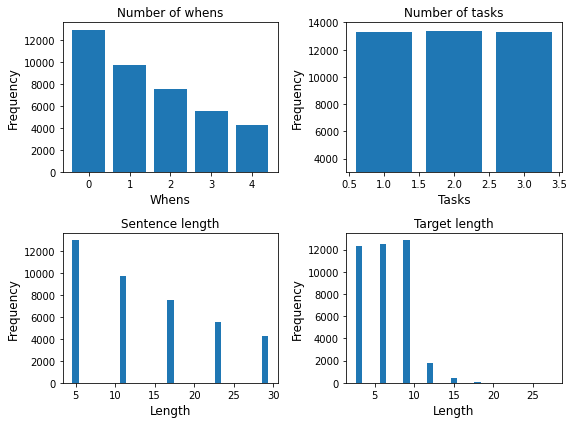

In [0]:
fontsize=12
plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.title("Number of whens", fontsize=12)
length_hist(data_list, include="depth")
plt.xlabel("Whens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.subplot(2,2,2)
plt.title("Number of tasks", fontsize=12)
length_hist(data_list, include="tasks")
plt.xlabel("Tasks", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.ylim(3000,None)
plt.subplot(2,2,3)
plt.title("Sentence length", fontsize=12)
length_hist(data_list, include="sentence")
plt.xlabel("Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.subplot(2,2,4)
plt.title("Target length", fontsize=12)
length_hist(data_list, include="target")
plt.xlabel("Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

In [0]:
#check if words in dev and test occur in train
train_words = get_unique_words(train)
dev_words = get_unique_words(dev)
test_words = get_unique_words(test)

for word in dev_words:
  if word not in train_words:
    print(f"{word} not in training set! (found in dev)")

for word in test_words:
  if word not in train_words:
    print(f"{word} not in training set! (found in test)")

In [0]:
# attempt to more natural ordered output
def remove_tasks(split):
  i = 0
  while split[i] in WWW:
    i += 2
  return split[i:]

def get_tasks(split):
  i = 0
  tasks = []
  while split[i] in WWW:
    tasks.append(split[i:i+2])
    i += 2
  return np.array(tasks)

def current_subsent(split, i):
  #only use at start of new subsentence
  www = ['','','']
  while www.count('') > 0:
    w = split[i]
    if w == "when":
      inwhen = 5
      while inwhen:
        i += 1
        inwhen -= 1
        if split[i] == "when":
          inwhen += 6
      w = split[i]
    elif w[:2] == "pe":
      www[0] = w
    elif w[:2] == "do":
      www[1] = w
    elif w[:2] == "lo":
      www[2] = w
    i += 1
  return www

def mask_subsent(split):
  mask = -2*np.ones(len(split))
  mask[np.array(split) == "when"] = -1
  marker = 0
  for i, m in enumerate(mask):
    if m != -1:
      mask[i] = marker
    elif m == -1:
      marker += 1
    while sum(mask==marker) == 5:
      if i < len(split)-1 and split[i+1] == "when":
        break
      else:
        marker -= 1
  return mask

def get_answer(split):
  tasks = get_tasks(split)
  no_tasks = remove_tasks(split)
  mask = mask_subsent(no_tasks)
  parts = ['' for i in range(1+int(np.max(mask)))]
  for i in range(1+int(np.max(mask))):
    parts[i] = current_subsent(no_tasks, int(np.where(mask == i)[0][0]))
  
  # for w in no_tasks:
  #   if w in ...

In [0]:
# sample = 26
# seq = train[sample][0]
# print(" ".join(remove_tasks(seq.split())))
# get_parts(seq.split())

at location5 person17 went doing12 when at location5 when person3 went doing1 at location14 person11 went doing7
[ 0.  0.  0.  0.  0. -1.  1.  1. -1.  2.  2.  2.  2.  2.  1.  1.  1.]


[['person17', 'doing12', 'location5'],
 ['person11', 'doing7', 'location5'],
 ['person3', 'doing1', 'location14']]

In [0]:

# === PCFG ===

# S -> W3 | W4
# W3 -> WHO what where | where WHO what
# W4 -> W3 when | when W3 | WHO what when where | where when WHO what 

# what -> went WHAT
# where -> at WHERE
# when -> "when" S

# WHO -> person0 | person1 | ...
# WHAT -> doing0 | doing1 | ...
# WHERE -> location0 | location1 | ...
